In [2]:
import requests
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
datafolder = 'workdata'

In [3]:
def getCountriesTable():
    """
        get the list of country available 
    """
    url = "https://api.covid19api.com/countries"
    payload = {}
    headers= {}
    response = requests.request("GET", url, headers=headers, data = payload)
    
    df=pd.DataFrame(response.json())
    df.to_csv(datafolder+'/countriesNameTable.csv')

getCountriesTable()

def getPandaFrameForCountry(CountryName):
    """
        return full data off covid19api for input CountryName
        JSON format to transform in dataframe
    """
    url = "https://api.covid19api.com/total/country/"+CountryName
    payload = {}
    headers= {}
    response = requests.request("GET", url, headers=headers, data = payload)
    return response.json()

def correctDateOnPandaFrame(pddf):
    """
        correct specific date column format
    """
    for i,elem in pddf.iterrows():
        splitdate = elem['Date'].split('T')
        newdate = datetime.strptime(splitdate[0], "%Y-%m-%d")
        pddf.at[i,'Date'] = newdate
        
def refresh_rawcsvfromAPI(payslist,datafolder,columnkeeplist):
    """
        get latest data from country list and replace RAW file
        
        DEPENDENCIES : getPandaFrameForCountry, correctDateOnPandaFrame
    """
    for paysname in payslist:
        rawdf=pd.DataFrame(getPandaFrameForCountry(paysname))
        # drop useless column
        rawdf.drop(rawdf.columns.difference(columnkeeplist), axis=1,inplace=True)
        # correct date
        correctDateOnPandaFrame(rawdf)
        
        filepath = datafolder+'/raw_'+paysname+'_ALLTable.csv'
        rawdf.to_csv(filepath,index=False)

In [4]:
REFRESH_CSV = True
# VARS
payslist = ['France','Germany','Italy','Spain','Belgium','United Kingdom']
columnkeeplist = ['Confirmed','Deaths','Recovered','Active','Date']
paysdf = {}

In [5]:
# EXECUTION 
# get raw data and write it down in csv format
if REFRESH_CSV : refresh_rawcsvfromAPI(payslist,datafolder,columnkeeplist)

# LOAD countries data from CSV files 
for paysname in payslist:
    filepath = datafolder+'/raw_'+paysname+'_ALLTable.csv'
    paysdf[paysname] = pd.read_csv(filepath)

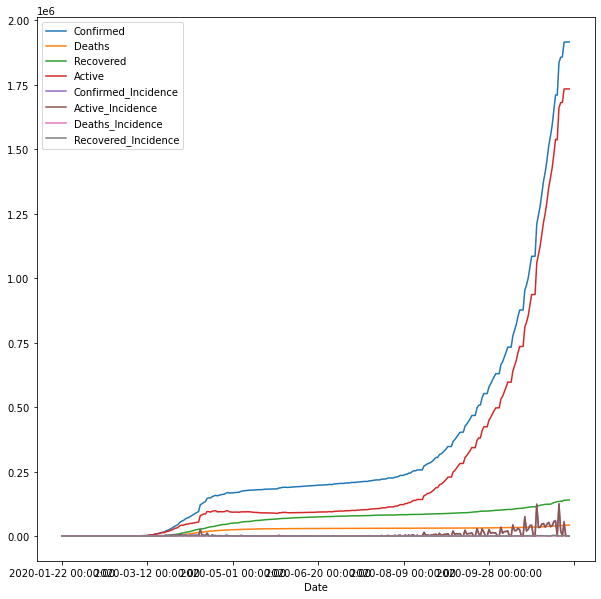

In [8]:
testdf = paysdf['France']
testdf
testdf.plot(kind='line',x='Date',figsize=(10,10))

In [51]:
# INCIDENCE TABLE CONSTRUCTION 
# GET supplementary case from day to day
def buildIncidence(rawData,columnName,smoothfactor):
    newdf = rawData[[columnName]]
    newdf['shift'] = newdf[columnName].shift(periods=1,fill_value=0)
    newdf['delta'] = newdf[columnName]-newdf['shift']
    # drop useless col
    newdf.drop(columnName, axis=1,inplace=True)
    newdf.drop('shift', axis=1,inplace=True)
    #ZEROING negative values
    newdf['delta'] = newdf['delta'].apply(lambda x: 0 if x < 0 else x)
    
    #smoothing values
    for i in range(1,smoothfactor+1):
        newdf['shift1'] = newdf['delta'].shift(periods=i,fill_value=0)
        newdf['shift-1'] = newdf['delta'].shift(periods=-i,fill_value=0)
        
    mean = newdf.mean(axis = 1)
    #print(mean.head())
    return mean

for paysname in payslist:
    currentdf = paysdf[paysname]
    currentdf['Confirmed_Incidence'] = buildIncidence(currentdf,'Confirmed',1)
    currentdf['Active_Incidence'] = buildIncidence(currentdf,'Active',1)
    currentdf['Deaths_Incidence'] = buildIncidence(currentdf,'Deaths',1)
    currentdf['Recovered_Incidence'] = buildIncidence(currentdf,'Recovered',1)
    #
    filepath = datafolder+'/incidence_'+paysname+'_Table.csv'
    currentdf.to_csv(filepath,index=False)
    paysdf[paysname] = currentdf


<ipython-input-51-56f6512f944f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['shift'] = newdf[columnName].shift(periods=1,fill_value=0)
<ipython-input-51-56f6512f944f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['delta'] = newdf[columnName]-newdf['shift']
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

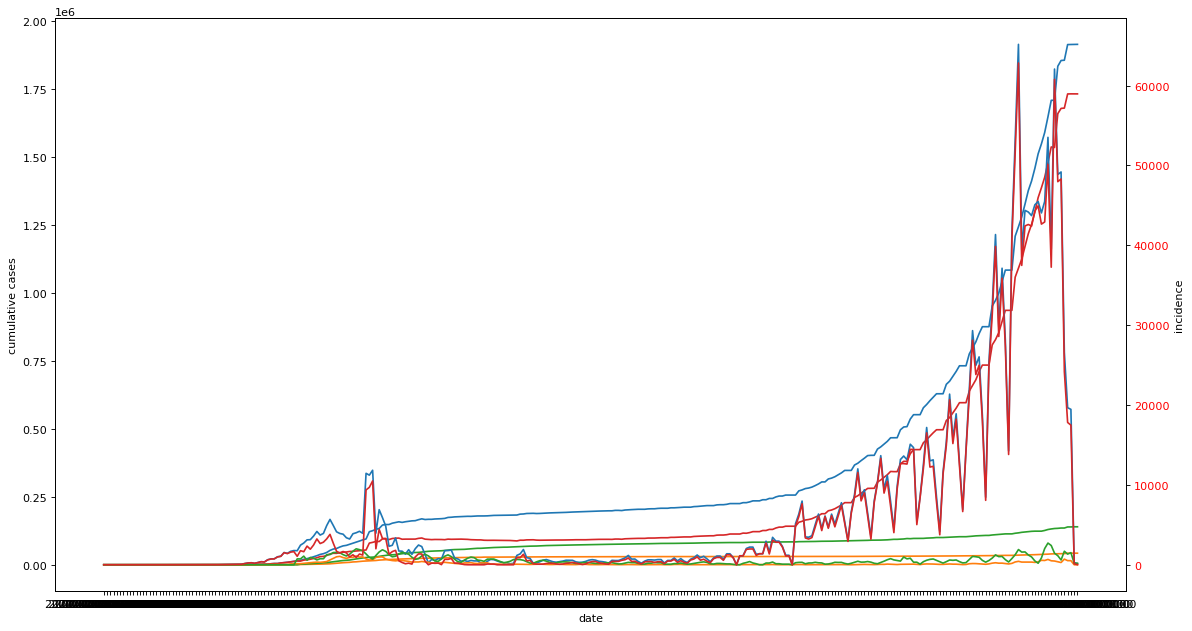

In [52]:
cur_df = paysdf['France']

fig, ax1 = plt.subplots(figsize=(15, 8), dpi=80)

ax1.set_xlabel('date')
ax1.set_ylabel('cumulative cases')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('incidence')  # we already handled the x-label with ax1

#colors = ['#878787', '#0c5792']
for name in ['Confirmed','Deaths','Recovered','Active']:
    ax1.plot(cur_df['Date'], cur_df[name])#, color=colors[i%2]) # plt.plot(x, y, "y-", color=colors[i%2])

#ax1.tick_params(axis='y', labelcolor=color)
for name in ['Confirmed_Incidence','Deaths_Incidence','Recovered_Incidence','Active_Incidence']:
    ax2.plot(cur_df['Date'], cur_df[name])#, color='red')
    
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

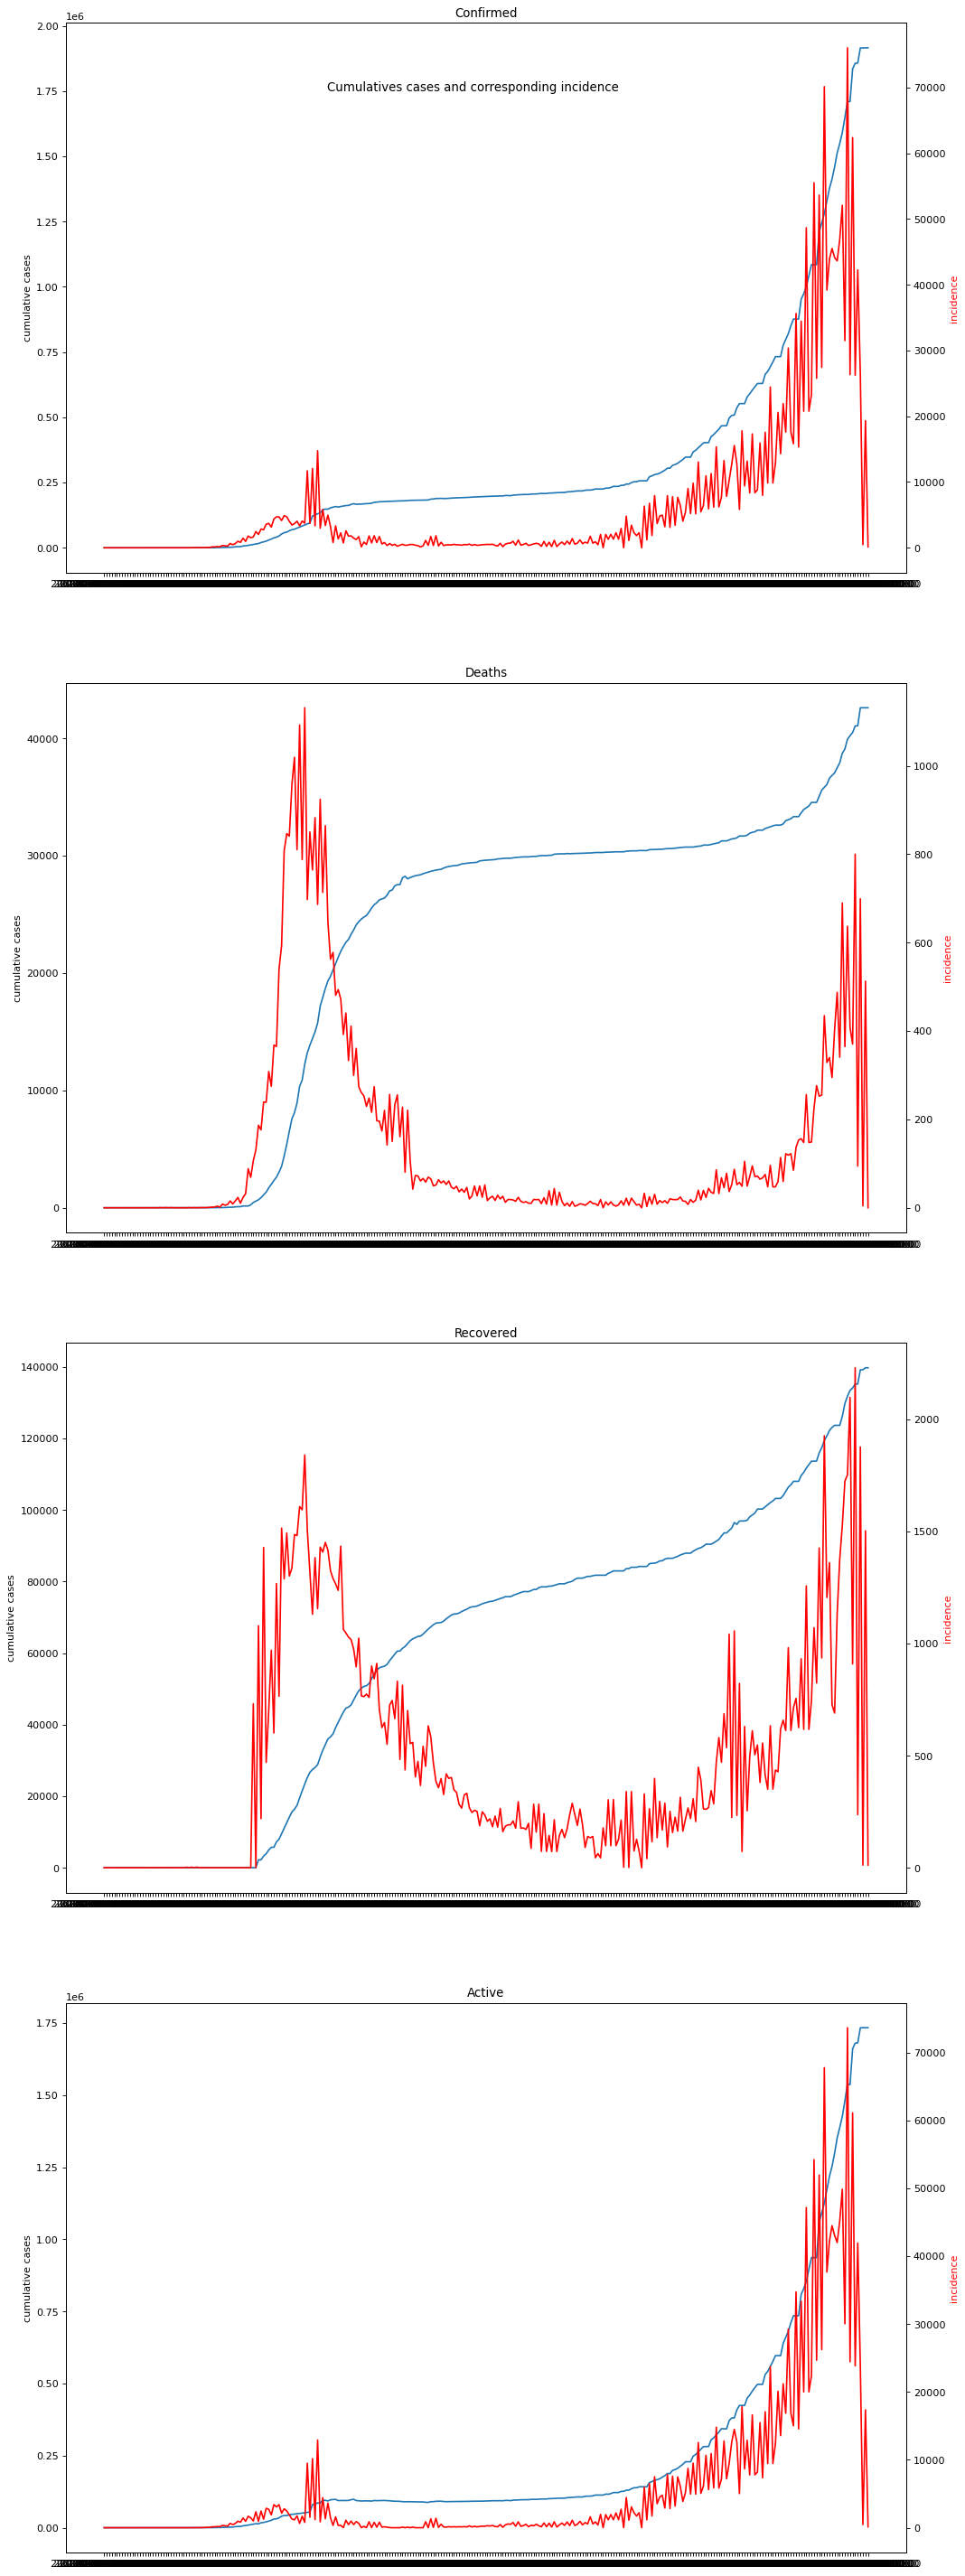

In [48]:
fig, axs = plt.subplots(4, 1,figsize=(15, 40), dpi=80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=None)
fig.suptitle('Cumulatives cases and corresponding incidence')

for nameCat,ax in zip(['Confirmed','Deaths','Recovered','Active'],axs.flat):
    ax.title.set_text(nameCat)
    ax.set_ylabel('cumulative cases')
    axbis = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axbis.set_ylabel('incidence',color='red')  # we already handled the x-label with ax1
    
    secondname = nameCat+'_Incidence'
    ax.plot(cur_df['Date'], cur_df[nameCat])
    axbis.plot(cur_df['Date'], cur_df[secondname],color='red')

plt.show()